In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [13]:

dataset_dir = 'drive/MyDrive/data'

# Specify the dimensions of your images
input_shape = (224, 224, 3)  # Adjust based on your image dimensions

# Specify the number of classes in your dataset
num_classes = len(os.listdir(dataset_dir))

# Data preparation and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify 'training' for the training set
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 2550 images belonging to 2 classes.
Found 282 images belonging to 2 classes.


In [14]:

base_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='sigmoid')(x)  # Change num_classes to the number of classes in your dataset

# Create a new model
model = Model(base_model.input, x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:

epochs = 50
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=epochs
)


Epoch 1/50
79/79 [==============================] - 76s 874ms/step - loss: 0.6496 - accuracy: 0.7228 - val_loss: 0.5826 - val_accuracy: 0.7422
Epoch 2/50
79/79 [==============================] - 58s 735ms/step - loss: 0.5819 - accuracy: 0.7339 - val_loss: 0.5925 - val_accuracy: 0.7227
Epoch 3/50
79/79 [==============================] - 64s 816ms/step - loss: 0.5852 - accuracy: 0.7327 - val_loss: 0.5867 - val_accuracy: 0.7266
Epoch 4/50
79/79 [==============================] - 61s 769ms/step - loss: 0.5832 - accuracy: 0.7327 - val_loss: 0.5828 - val_accuracy: 0.7305
Epoch 5/50
79/79 [==============================] - 64s 815ms/step - loss: 0.5824 - accuracy: 0.7335 - val_loss: 0.5905 - val_accuracy: 0.7227
Epoch 6/50
79/79 [==============================] - 60s 758ms/step - loss: 0.5808 - accuracy: 0.7347 - val_loss: 0.5762 - val_accuracy: 0.7383
Epoch 7/50
79/79 [==============================] - 58s 733ms/step - loss: 0.5817 - accuracy: 0.7323 - val_loss: 0.5789 - val_accuracy: 0.7344

In [10]:
from PIL import Image
import os

def is_image_file(filepath):
    try:
        # Try to open the image file
        Image.open(filepath).verify()
        return True
    except Exception as e:
        # Print the exception (you can customize this part based on your needs)
        print(f"Error opening {filepath}: {e}")
        return False

def delete_unopenable_files(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Iterate through each file
    for file in files:
        file_path = os.path.join(folder_path, file)

        # Check if the file is an image and can be opened
        if not is_image_file(file_path):
            # If not, delete the file
            os.remove(file_path)
            print(f"Deleted {file_path}")

# Specify the path to your folder
folder_path = 'drive/MyDrive/data/iconography'

# Call the function to delete unopenable files
delete_unopenable_files(folder_path)


Error opening drive/MyDrive/data/iconography/331.jpg: cannot identify image file 'drive/MyDrive/data/iconography/331.jpg'
Deleted drive/MyDrive/data/iconography/331.jpg
Error opening drive/MyDrive/data/iconography/69.jpg: cannot identify image file 'drive/MyDrive/data/iconography/69.jpg'
Deleted drive/MyDrive/data/iconography/69.jpg


In [16]:
model.save('2class_new.h5')

In [154]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
from tensorflow.keras.models import load_model

In [155]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [156]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


In [157]:
vgg = load_model('2class_new.h5')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten_1
dense_2
dense_3


In [158]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [159]:
def vgg_layers(layer_names):

  vgg = load_model('2class_new.h5')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [221]:
content_path = '136.jpg'
style_path = 'Untitled.jpg'

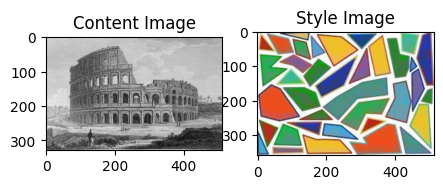

In [222]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [223]:
style_extractor = vgg_layers(style_layers)
content_image = tf.image.resize(content_image, (224, 224))
style_image = tf.image.resize(style_image, (224, 224))
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 224, 224, 64)
  min:  0.0
  max:  172.29892
  mean:  15.028507

block2_conv1
  shape:  (1, 112, 112, 128)
  min:  0.0
  max:  46.168835
  mean:  1.3280226

block3_conv1
  shape:  (1, 56, 56, 256)
  min:  0.0
  max:  13.605077
  mean:  0.2255347

block4_conv1
  shape:  (1, 28, 28, 512)
  min:  0.0
  max:  1.6821502
  mean:  0.04680252

block5_conv1
  shape:  (1, 14, 14, 512)
  min:  0.0
  max:  2.2877223
  mean:  0.13307516



In [224]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [225]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [226]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0219687
    max:  1191.5692
    mean:  42.886456

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  130.985
    mean:  0.37364882

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  10.710735
    mean:  0.01028039

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  0.017637562
    mean:  5.7926867e-05

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  0.03534466
    mean:  0.00026780795

Contents:
   block5_conv2
    shape:  (1, 14, 14, 512)
    min:  0.0
    max:  0.7886697
    mean:  0.0108510945


In [227]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [228]:
image = tf.Variable(content_image)

In [229]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [230]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [231]:
style_weight=1e4
content_weight=1e4

In [232]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [233]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

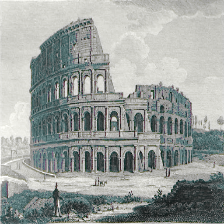

In [234]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

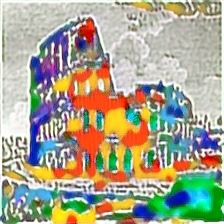

Train step: 2500
Total time: 51.6


In [235]:
import time
start = time.time()

epochs = 25
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [179]:
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [25]:
from tensorflow.keras.preprocessing.image import array_to_img
#vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg = load_model('2class_new.h5')
def tensor_to_image(tensor, channel_index=0):
    # Check if the tensor has a batch dimension and squeeze it
    if len(tensor.shape) == 4:
        assert tensor.shape[0] == 1  # Ensure it's a single example in the batch
        tensor = np.squeeze(tensor, axis=0)

    assert len(tensor.shape) == 3  # Ensure it's a 3D tensor
    tensor_channel = tensor[:, :, channel_index]  # Select a specific channel
    tensor_rgb = np.stack((tensor_channel,) * 3, axis=-1)  # Stack to create a 3-channel image
    tensor_rgb = tensor_rgb.astype(np.uint8)  # Convert to NumPy array
    return array_to_img(tensor_rgb)


1/1 [==============================] - 0s 94ms/step


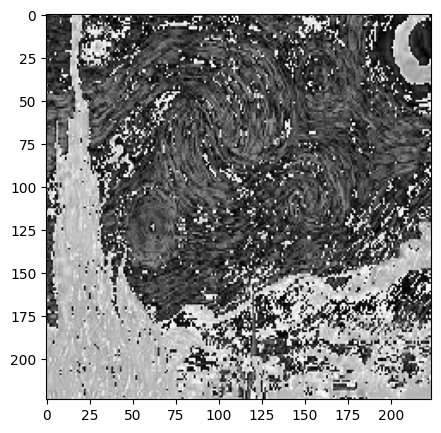

input_2
1/1 [==============================] - 0s 100ms/step


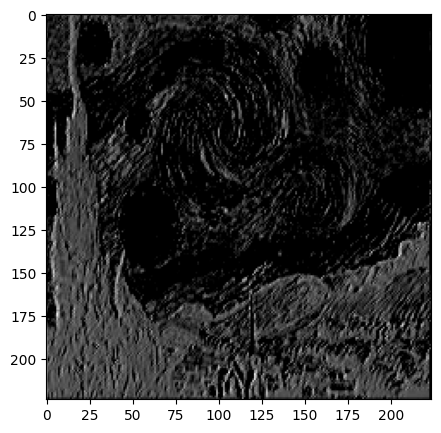

block1_conv1
1/1 [==============================] - 0s 42ms/step


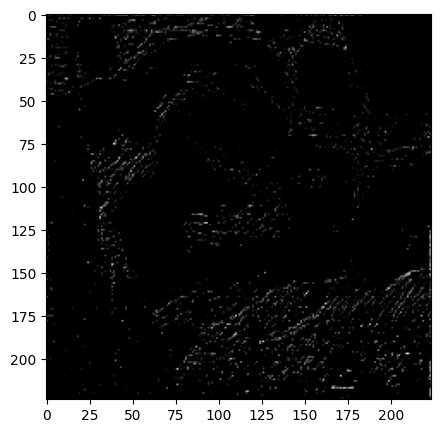

block1_conv2
1/1 [==============================] - 0s 82ms/step


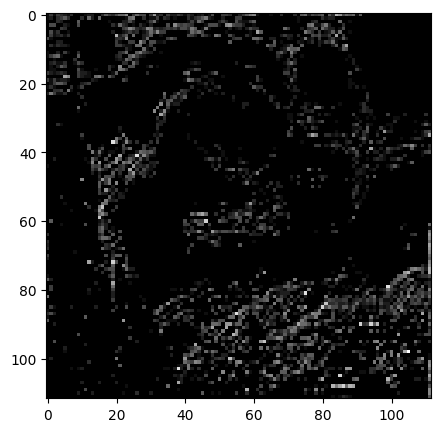

block1_pool
1/1 [==============================] - 0s 201ms/step


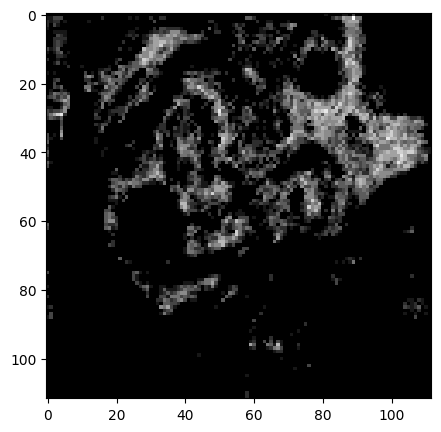

block2_conv1
1/1 [==============================] - 0s 326ms/step


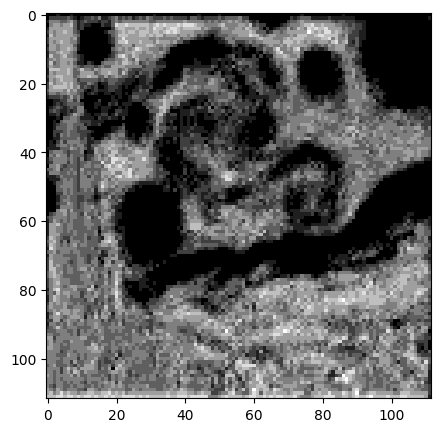

block2_conv2
1/1 [==============================] - 0s 240ms/step


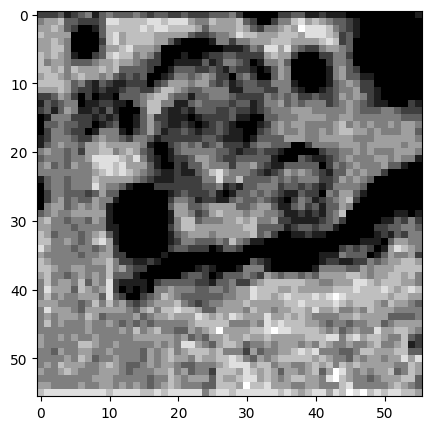

block2_pool
1/1 [==============================] - 0s 393ms/step


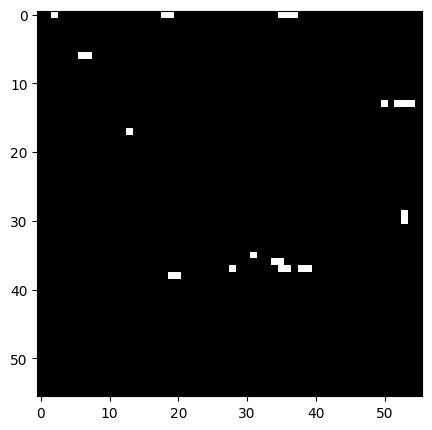

block3_conv1
1/1 [==============================] - 0s 437ms/step


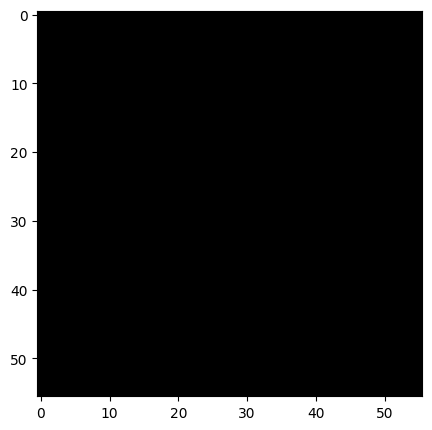

block3_conv2
1/1 [==============================] - 0s 439ms/step


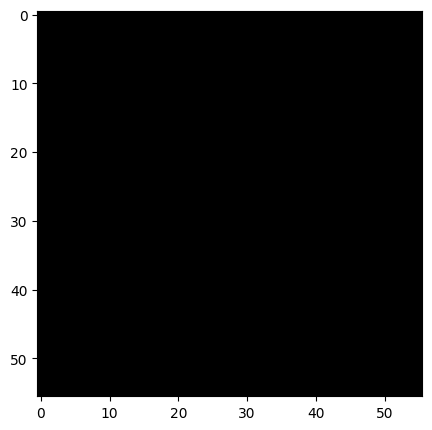

block3_conv3
1/1 [==============================] - 0s 310ms/step


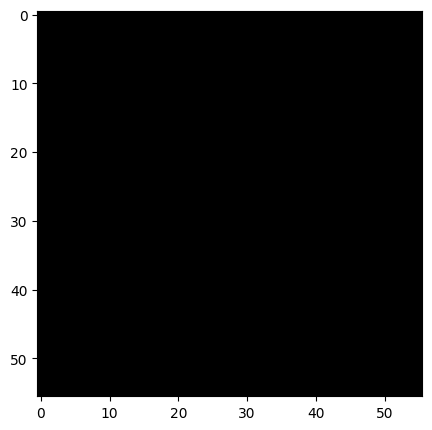

block3_conv4
1/1 [==============================] - 0s 158ms/step


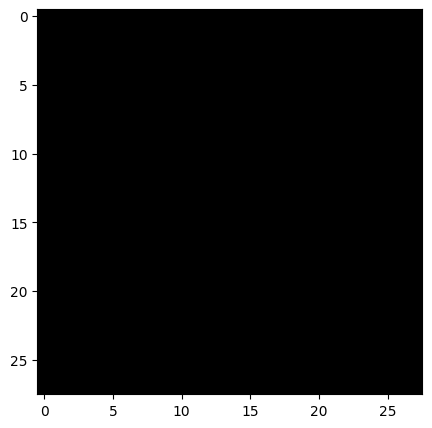

block3_pool
1/1 [==============================] - 0s 187ms/step


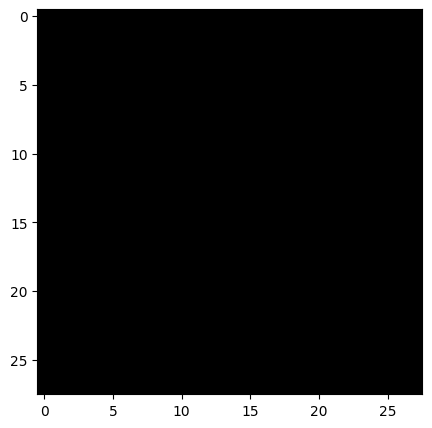

block4_conv1
1/1 [==============================] - 0s 183ms/step


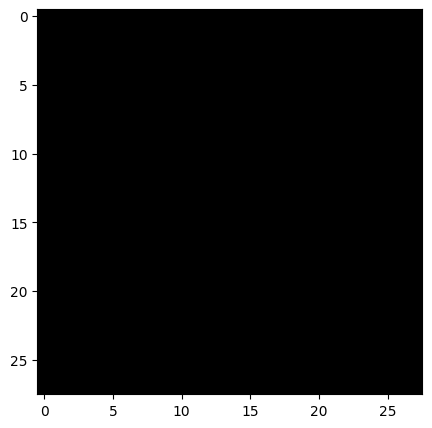

block4_conv2
1/1 [==============================] - 0s 488ms/step


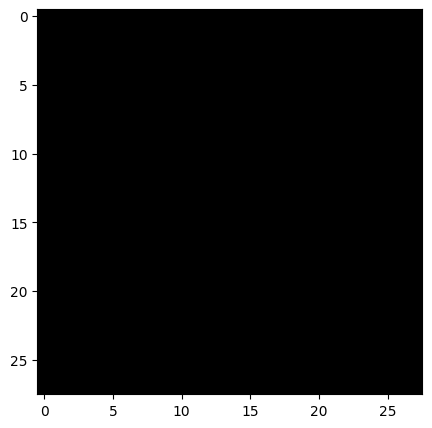

block4_conv3
1/1 [==============================] - 0s 115ms/step


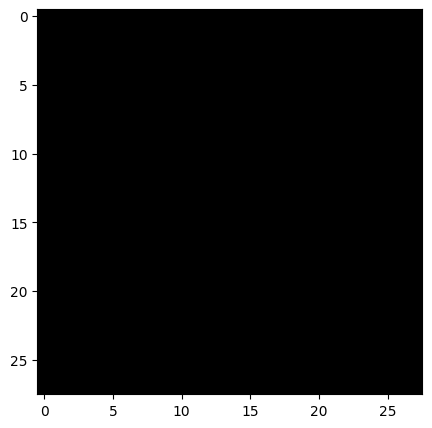

block4_conv4
1/1 [==============================] - 0s 134ms/step


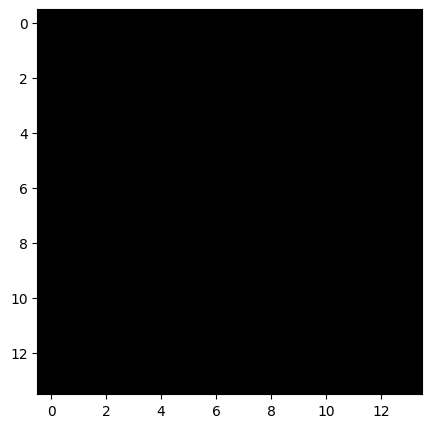

block4_pool
1/1 [==============================] - 0s 118ms/step


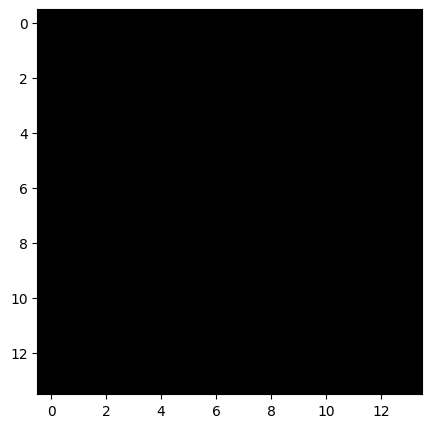

block5_conv1
1/1 [==============================] - 0s 123ms/step


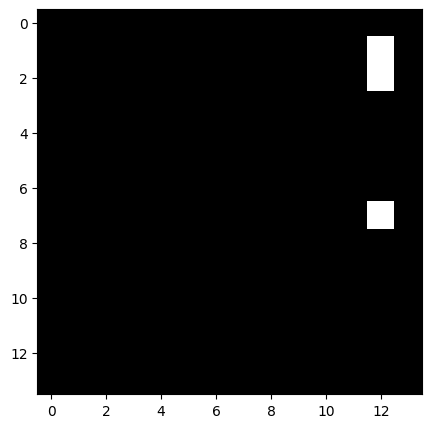

block5_conv2
1/1 [==============================] - 0s 129ms/step


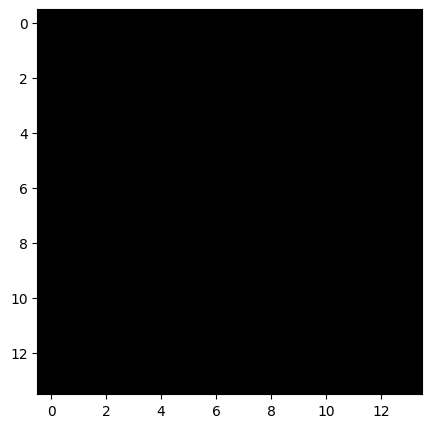

block5_conv3
1/1 [==============================] - 0s 148ms/step


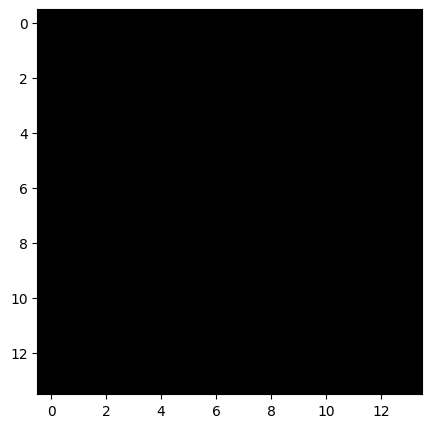

block5_conv4
1/1 [==============================] - 0s 159ms/step


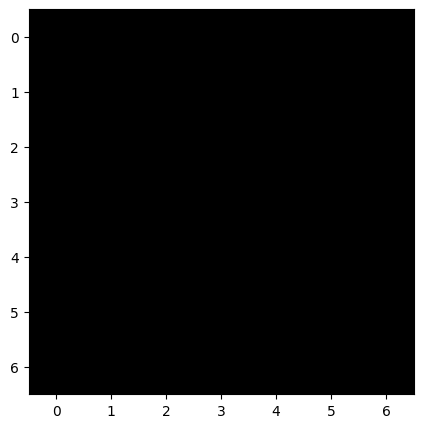

block5_pool


In [27]:
for l in vgg.layers:
  layer = l.name
  m = Model(inputs = vgg.input, outputs = vgg.get_layer(layer).output)

  #img_path = 'images/resized/Albrecht_Du╠êrer/Albrecht_Du╠êrer_2.jpg'
  img_path = 'the-starry-night.jpg'
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)
  plt.imshow(tensor_to_image(m.predict(img_array), channel_index= 0))
  plt.show()
  print(layer)
  if layer == 'block5_pool':
    break

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten_3
dense_7
dense_8

In [173]:
! pip install utils

In [174]:
import os
import datetime

import tensorflow as tf
from matplotlib import pyplot as plt

from utils.image_transformation import random_jitter, normalize, resize
from utils.model_utils import u_net_generator, discriminator, plot_transformations, create_training_function, \
    get_instance_data_set_generator, plot_transformation

ModuleNotFoundError: ignored